In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import scipy.optimize
import random
from sklearn import svm
from sklearn import linear_model
from collections import defaultdict
import math
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('events.csv')
#df.head(20)

In [3]:
filtered_df = df[df["event_type"] == 1]
filtered_df.head(5)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,13.0,2.0,0,15.0,1.0,1,1.0,0
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,4.0,1.0,1,9.0,2.0,1,1.0,0
14,UFot0hit/,UFot0hit15,15,19,Attempt blocked. Mats Hummels (Borussia Dortmu...,1,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,2.0,3.0,0,15.0,1.0,0,1.0,0
17,UFot0hit/,UFot0hit18,18,20,Attempt blocked. Tomas Rincon (Hamburg) right ...,1,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,2.0,3.0,0,15.0,1.0,0,1.0,0


In [42]:
filtered_df = filtered_df[filtered_df["event_type2"] != 15]
#len(filtered_df)

In [43]:
filtered_df = filtered_df[filtered_df['time'].notnull()]
#len(filtered_df)

In [44]:
filtered_df = filtered_df[filtered_df['player'].notnull()]
#len(filtered_df)

In [45]:
filtered_df = filtered_df[filtered_df['event_team'].notnull()]
#len(filtered_df)

In [46]:
filtered_df = filtered_df[filtered_df['opponent'].notnull()]
#len(filtered_df)

In [47]:
filtered_df = filtered_df[filtered_df['side'].notnull()]
#len(filtered_df)

In [48]:
filtered_df = filtered_df[filtered_df['shot_place'].notnull()]
#len(filtered_df)

In [49]:
filtered_df = filtered_df[filtered_df['location'].notnull()]
#len(filtered_df)

In [50]:
filtered_df = filtered_df[filtered_df['bodypart'].notnull()]
#len(filtered_df)

In [51]:
filtered_df = filtered_df[filtered_df['assist_method'].notnull()]
#len(filtered_df)

In [52]:
filtered_df = filtered_df[filtered_df['situation'].notnull()]
#len(filtered_df)

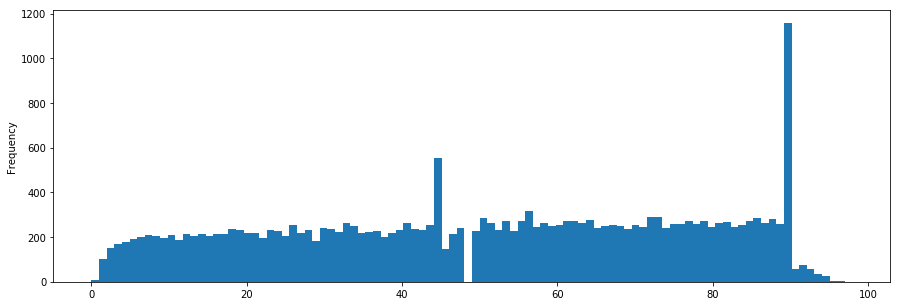

In [53]:
goals = filtered_df[filtered_df['is_goal'] == 1]
plt.figure();
goals['time'].plot.hist(bins=100, figsize=(15,5))

([<matplotlib.axis.XTick at 0x2177a5c0>,
 <a list of 13 Text xticklabel objects>)

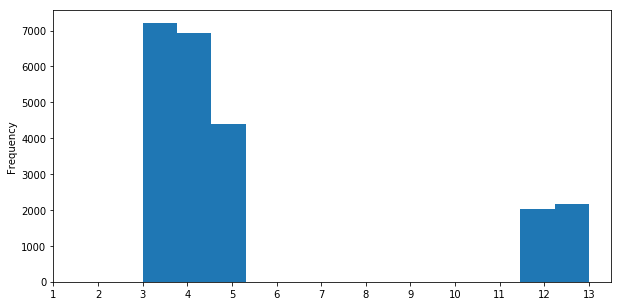

In [54]:
goals['shot_place'].plot.hist(bins=13, figsize=(10,5));
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])

([<matplotlib.axis.XTick at 0x44cefda0>,
 <a list of 13 Text xticklabel objects>)

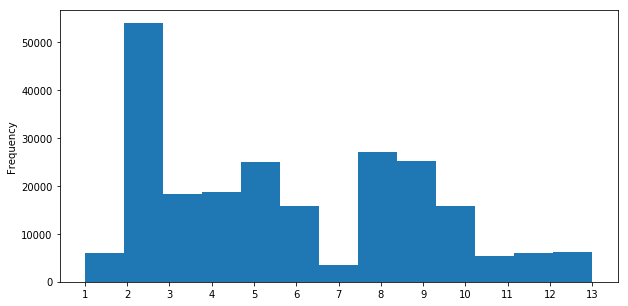

In [55]:
filtered_df['shot_place'].plot.hist(bins=13,figsize=(10,5))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])

([<matplotlib.axis.XTick at 0x478b5c50>,
 <a list of 20 Text xticklabel objects>)

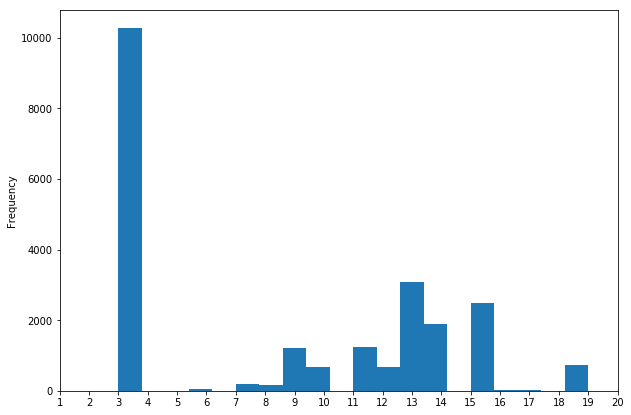

In [56]:
goals['location'].plot.hist(bins=20,figsize=(10,7))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [57]:
sample = filtered_df.sample(frac=1)
#sample.head()

In [58]:
X_train = []
X_validation = []
X_test = []

length = int(len(sample) / 3)

X_train = sample[:length]
X_validation = sample[length:length*2]
X_test = sample[length*2:]

X_train_goals = X_train[X_train['is_goal'] == 1]
X_train_nongoals = X_train[X_train['is_goal'] == 0]

In [59]:
X_train_nongoals = X_train_nongoals[:len(X_train_goals)]
frames = [X_train_nongoals, X_train_goals]
X_train = pd.concat(frames)
len(X_train)

14912

In [60]:
team_dict = defaultdict(int)
player_dict_goals = defaultdict(int)
player_dict_shots = defaultdict(int)
player_dict = defaultdict(int)
team_count = 0
player_count = 0
count = 0
for index, row in sample.iterrows():
    team1 = row['event_team']
    team2 = row['opponent']
    player = row['player']
    is_goal = row['is_goal']
    if (team1 not in team_dict):
        team_dict[team1] = team_count
        team_count += 1
    if (team2 not in team_dict):
        team_dict[team2] = team_count
        team_count += 1
    if (player not in player_dict):
        player_dict[player] = player_count
        player_count += 1
    
    player_dict_shots[player] += 1
    player_dict_goals[player] += is_goal

In [61]:
team_dict = defaultdict(int)
team_dict_shots = defaultdict(int)
team_dict_goals = defaultdict(int)
team_dict_shots_conceded = defaultdict(int)
team_dict_goals_conceded = defaultdict(int)
player_dict_goals = defaultdict(int)
player_dict_shots = defaultdict(int)
player_dict = defaultdict(int)
team_count = 0
player_count = 0
count = 0
for index, row in sample.iterrows():
    team1 = row['event_team']
    team2 = row['opponent']
    player = row['player']
    is_goal = row['is_goal']
    if (team1 not in team_dict):
        team_dict[team1] = team_count
        team_count += 1
    if (team2 not in team_dict):
        team_dict[team2] = team_count
        team_count += 1
    if (player not in player_dict):
        player_dict[player] = player_count
        player_count += 1
    team_dict_shots_conceded[team2] += 1
    team_dict_goals_conceded[team2] += is_goal
    team_dict_shots[team1] += 1
    team_dict_goals[team1] += is_goal
    player_dict_shots[player] += 1
    player_dict_goals[player] += is_goal

In [65]:
##############
##############
##############
#MY CODE BELOW
##############
##############
##############

In [62]:
def feature(datum):
    feat = []
    
    # player
    player = datum['player']
    #player goal percentage
    shot_perc = 0
    if player_dict_goals[player] != 0:
        shot_perc = player_dict_shots[player]/player_dict_goals[player]
    #team
    team = datum['event_team']
    #team goal percentage
    team_shot_perc = 0
    if team_dict_goals[team] != 0:
        team_shot_perc = team_dict_shots[team]/team_dict_goals[team]
    #opponent
    opponent = datum['opponent']
    #opponent goal percentage conceded
    opp_shot_perc = 0
    if team_dict_goals_conceded[opponent] != 0:
        opp_shot_perc = team_dict_goals_conceded[opponent]/team_dict_shots_conceded[opponent]
        
    opp_team_ratio = 0
    if opp_shot_perc !=0:
        opp_team_ratio = team_shot_perc/opp_shot_perc
    
    #feat = [shot_perc, datum['time'], datum['shot_place'], datum['location'], datum['bodypart'], datum['assist_method'], datum['situation']]
    feat = [shot_perc, team_dict_goals[team], team_dict_goals_conceded[opponent], datum['time'], datum['shot_place'], datum['location'], datum['bodypart'], datum['assist_method'], datum['situation']]

    return feat

X_train_SVM = [feature(d) for index, d in X_train.iterrows()]
Y_train_SVM =[d['is_goal'] == 1 for index, d in X_train.iterrows()]

X_validation_SVM = [feature(d) for index, d in X_validation.iterrows()]
Y_validation_SVM =[d['is_goal'] == 1 for index, d in X_validation.iterrows()]

In [63]:
# Create a support vector classifier object, with regularization parameter C = 1000
#clf = svm.LinearSVC(C=1)
clf = RandomForestClassifier(max_depth=16, random_state=0)
#clf = linear_model.LogisticRegression(C=0.1)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
 #                   hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train_SVM, Y_train_SVM)

train_predictions = clf.predict(X_train_SVM)

correct = 0
current = 0
for pred in train_predictions:
    if pred == Y_train_SVM[current]:
        correct += 1
    current += 1
accuracy = correct * 1.0/len(train_predictions)
print('Train accuracy: ' + str(accuracy))


validation_predictions = clf.predict(X_validation_SVM)

correct = 0
current = 0
for pred in validation_predictions:
    if pred == Y_validation_SVM[current]:
        correct += 1
    current += 1
accuracy = correct * 1.0/len(validation_predictions)
print('Validation accuracy: ' + str(accuracy))

X_test_SVM = [feature(d) for index, d in X_test.iterrows()]
Y_test_SVM =[d['is_goal'] == 1 for index, d in X_test.iterrows()]

test_predictions = clf.predict(X_test_SVM)

correct = 0
current = 0
for pred in test_predictions:
    if pred == Y_test_SVM[current]:
        correct += 1
    current += 1
accuracy = correct * 1.0/len(test_predictions)
print('Test accuracy: ' + str(accuracy))

Train accuracy: 0.957685085837
Validation accuracy: 0.855565376852
Test accuracy: 0.853867363227


In [64]:
clf.feature_importances_

array([ 0.06183031,  0.04035749,  0.04309516,  0.0462748 ,  0.61737219,
        0.13088107,  0.01285733,  0.02028341,  0.02704825])